In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import episcanpy.api as epi

sc.settings.verbosity = 3

/Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

# scRNA-seq

In [3]:
SCRNA_DIR = '../data/granja-2019/scRNA/'
SCATAC_DIR = '../data/granja-2019/scATAC/'
SCADT_DIR = '../data/granja-2019/scADT/'

In [8]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_symbols', cache=True)

var = pd.read_csv(SCRNA_DIR + 'var.csv')
var.index = var.gene_name
scrna.var = var

obs = pd.read_csv(SCRNA_DIR + 'obs.csv')
obs.index = obs.iloc[:,0]
scrna.obs = obs

... writing an h5ad cache file to speedup reading next time
CPU times: user 3min 36s, sys: 23.5 s, total: 4min
Wall time: 4min 29s


In [9]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287
    obs: 'Unnamed: 0', 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'ProjectUMAP1', 'ProjectUMAP2', 'ProjectClassification', 'Barcode'
    var: 'gene_name', 'gene_id', 'exonLength'

In [10]:
scrna.obs.head()

Unnamed: 0      Group  nUMI_pre  nUMI  \
Unnamed: 0                                                                  
RM2:AAACCTGAGTGTCCCG-1  RM2:AAACCTGAGTGTCCCG-1  MPAL5R_T1      1802  1441   
RM2:AAAGATGGTCCGAGTC-1  RM2:AAAGATGGTCCGAGTC-1  MPAL5R_T1     12368  7988   
RM2:AAATGCCCAAATTGCC-1  RM2:AAATGCCCAAATTGCC-1  MPAL5R_T1      1945  1036   
RM2:AAATGCCTCGTTACAG-1  RM2:AAATGCCTCGTTACAG-1  MPAL5R_T1      2529  1551   
RM2:AACACGTAGGAGCGAG-1  RM2:AACACGTAGGAGCGAG-1  MPAL5R_T1      5864  3774   

                        nGene  ProjectUMAP1  ProjectUMAP2  \
Unnamed: 0                                                  
RM2:AAACCTGAGTGTCCCG-1    896     -6.581877      3.819128   
RM2:AAAGATGGTCCGAGTC-1   3029     -6.184691      2.277092   
RM2:AAATGCCCAAATTGCC-1    600     -5.550443      2.505810   
RM2:AAATGCCTCGTTACAG-1    957     -5.936206      2.888241   
RM2:AACACGTAGGAGCGAG-1   1592     -6.512098     -0.113418   

                       ProjectClassification             Barcode  
Unnamed: 0                                                        
RM2:AAACCTGAGTGTCCCG-1       Progenitor_Like  AAACCTGAGTGTCCCG-1  
RM2:AAAGATGGTCCGAGTC-1          Myeloid_Like  AAAGATGGTCCGAGTC-1  
RM2:AAATGCCCAAATTGCC-1          Myeloid_Like  AAATGCCCAAATTGCC-1  
RM2:AAATGCCTCGTTACAG-1       Progenitor_Like  AAATGCCTCGTTACAG-1  
RM2:AACACGTAGGAGCGAG-1          Myeloid_Like  AACACGTAGGAGCGAG-1

In [11]:
scrna.var.head()

gene_name          gene_id  exonLength
gene_name                                          
FAM138A        FAM138A  ENSG00000237613        1219
OR4F5            OR4F5  ENSG00000186092         918
AL627309.1  AL627309.1  ENSG00000237683        2661
OR4F29          OR4F29  ENSG00000235249         995
OR4F16          OR4F16  ENSG00000185097         995

## Data Cleaning

In [12]:
scrna.obs.drop('Unnamed: 0', axis=1, inplace=True)

In [13]:
scrna.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

In [14]:
scrna.obsm['X_umap'] = scrna.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scrna.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

In [15]:
scrna.obs['condition'] = scrna.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [16]:
scrna.obs.head()

Group  nUMI_pre  nUMI  nGene        cell_type  \
Unnamed: 0                                                                  
RM2:AAACCTGAGTGTCCCG-1  MPAL5R_T1      1802  1441    896  Progenitor_Like   
RM2:AAAGATGGTCCGAGTC-1  MPAL5R_T1     12368  7988   3029     Myeloid_Like   
RM2:AAATGCCCAAATTGCC-1  MPAL5R_T1      1945  1036    600     Myeloid_Like   
RM2:AAATGCCTCGTTACAG-1  MPAL5R_T1      2529  1551    957  Progenitor_Like   
RM2:AACACGTAGGAGCGAG-1  MPAL5R_T1      5864  3774   1592     Myeloid_Like   

                                   Barcode   condition  
Unnamed: 0                                              
RM2:AAACCTGAGTGTCCCG-1  AAACCTGAGTGTCCCG-1  stimulated  
RM2:AAAGATGGTCCGAGTC-1  AAAGATGGTCCGAGTC-1  stimulated  
RM2:AAATGCCCAAATTGCC-1  AAATGCCCAAATTGCC-1  stimulated  
RM2:AAATGCCTCGTTACAG-1  AAATGCCTCGTTACAG-1  stimulated  
RM2:AACACGTAGGAGCGAG-1  AACACGTAGGAGCGAG-1  stimulated

In [17]:
scrna.var = scrna.var.drop('gene_name', axis=1)
scrna.var.head()

gene_id  exonLength
gene_name                              
FAM138A     ENSG00000237613        1219
OR4F5       ENSG00000186092         918
AL627309.1  ENSG00000237683        2661
OR4F29      ENSG00000235249         995
OR4F16      ENSG00000185097         995

We just store the raw data, before quality control and normalization:

In [18]:
%time scrna.write(SCRNA_DIR + 'expressions-raw.h5ad')

... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'condition' as categorical


CPU times: user 1.41 s, sys: 1.25 s, total: 2.66 s
Wall time: 5 s


## Quality Control

Data is already quality controlled by the authors. Here we just plot to show this fact.

normalizing counts per cell
    finished (0:00:03)


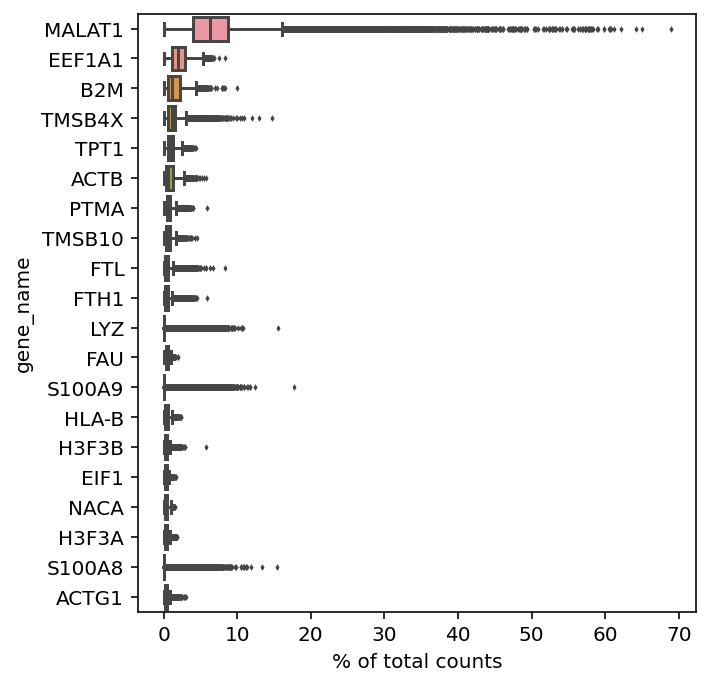

In [19]:
sc.pl.highest_expr_genes(scrna, n_top=20)

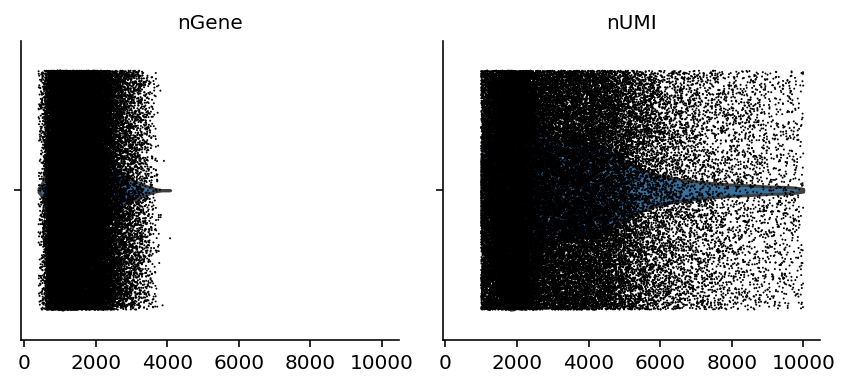

In [20]:
sc.pl.violin(scrna, ['nGene', 'nUMI'], jitter=0.4, multi_panel=True)

## Normalization

In [21]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

normalizing counts per cell
    finished (0:00:03)


In [22]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_id', 'exonLength'
    uns: 'log1p'
    obsm: 'X_umap'

## Filtering Highly Variable Genes

In [23]:
sc.pp.highly_variable_genes(scrna, n_top_genes=3000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


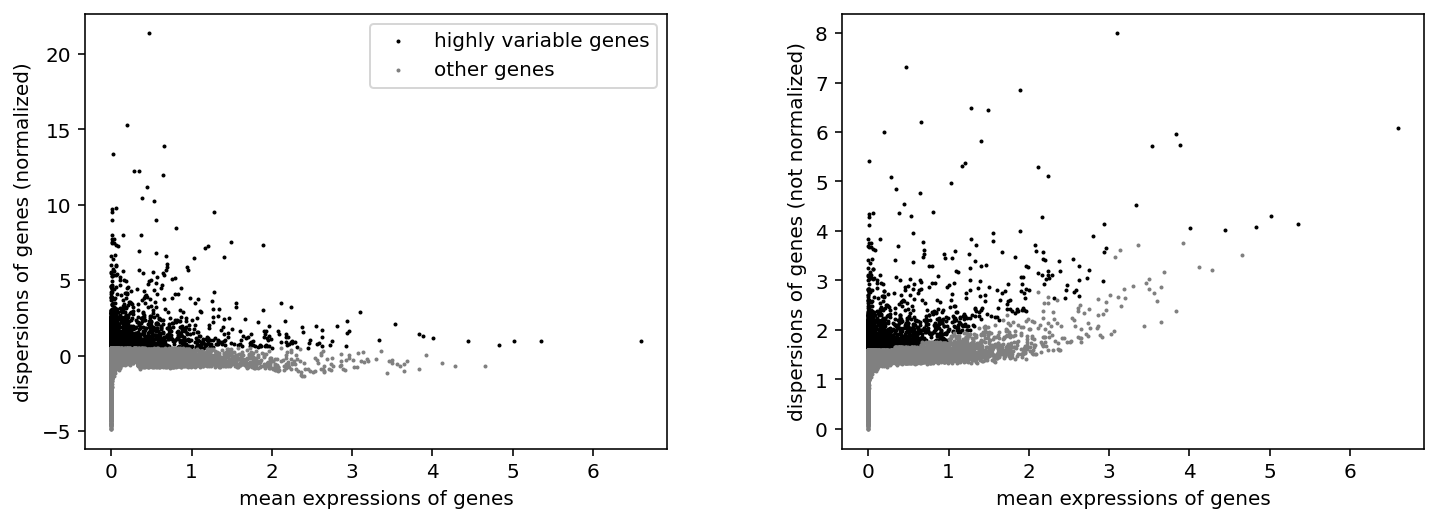

In [24]:
sc.pl.highly_variable_genes(scrna)

In [25]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 53638 × 3000
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_umap'

## Visualization

### UMAP using coordinates provided by the authors

Trying to set attribute `.uns` of view, copying.


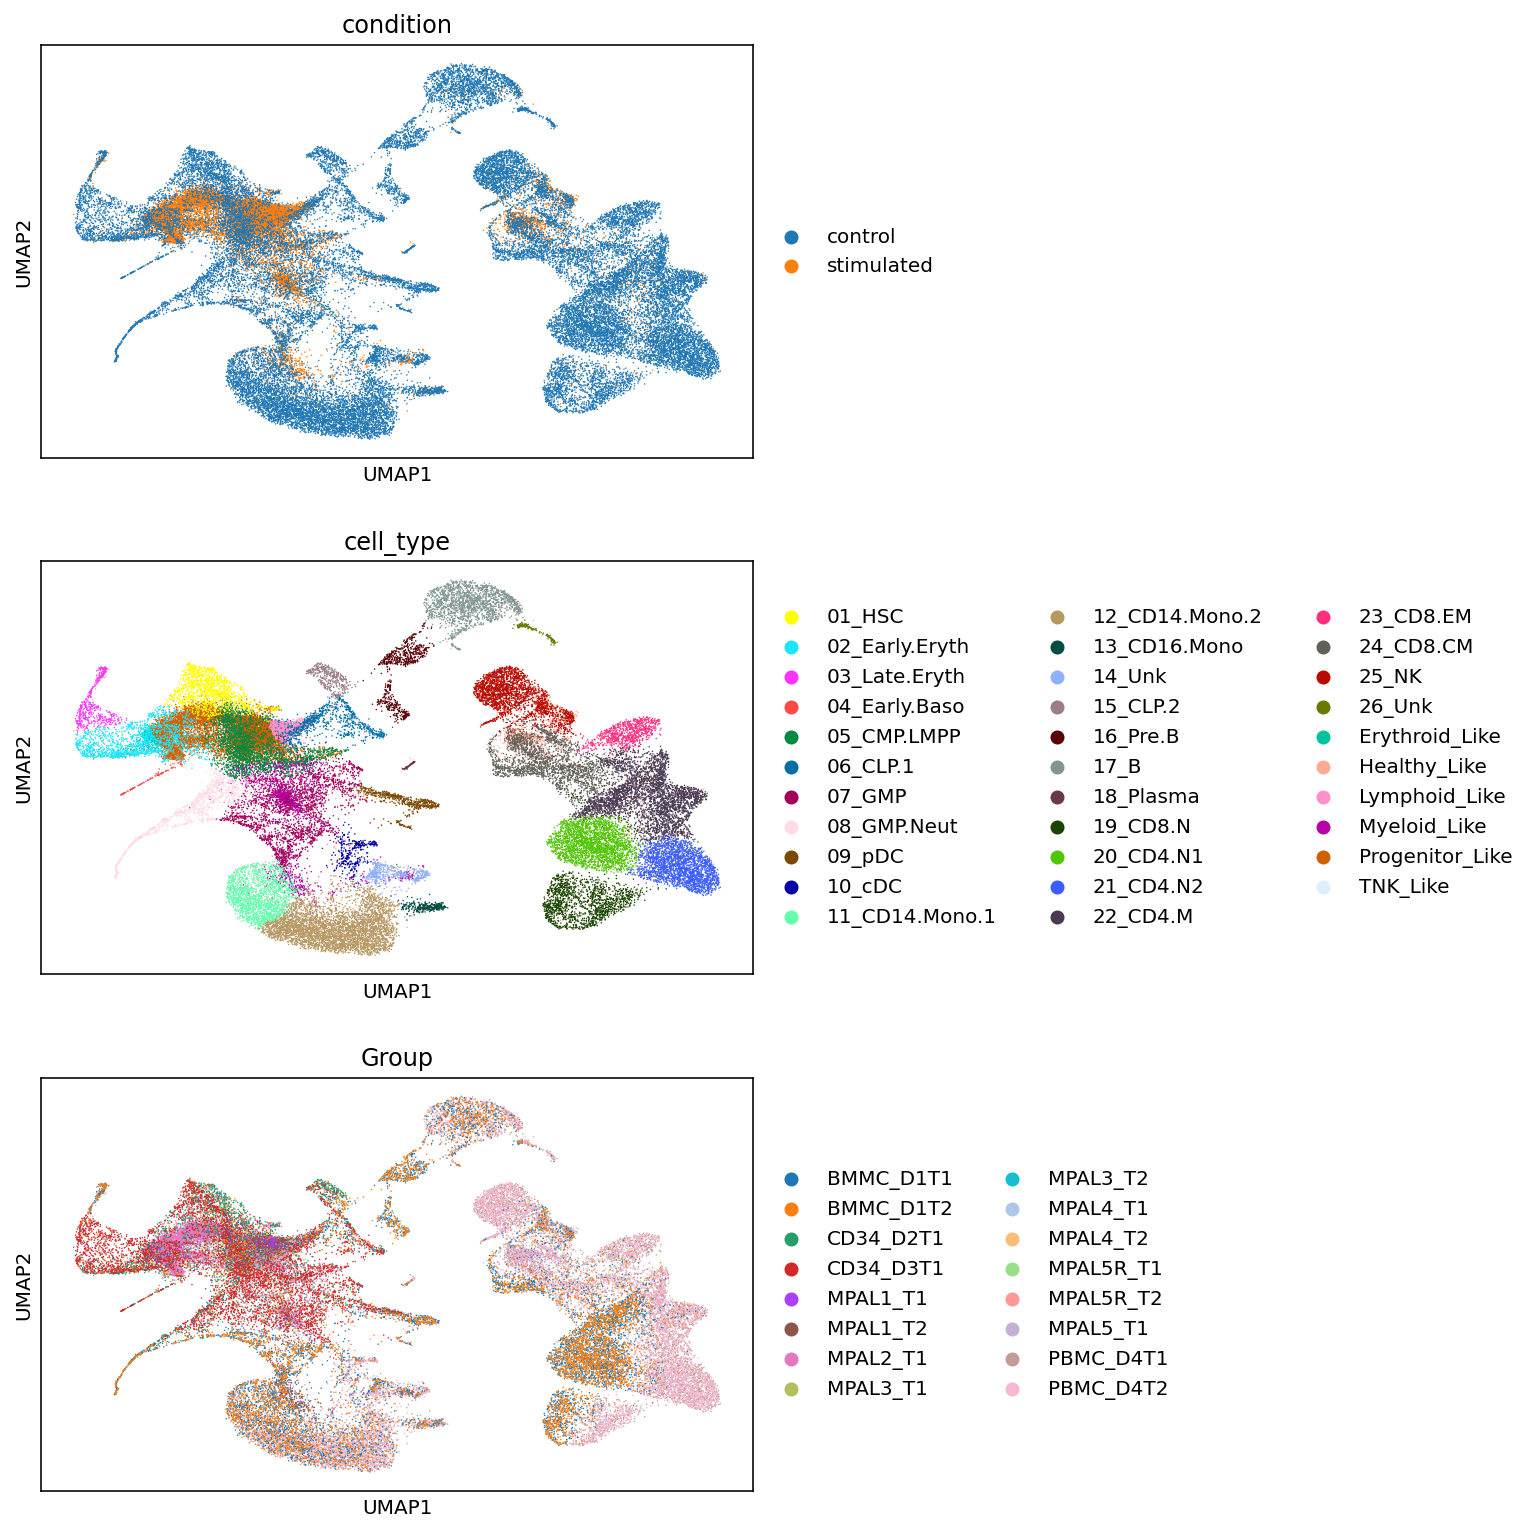

In [26]:
sc.pl.umap(scrna, color=['condition', 'cell_type', 'Group'], ncols=1)

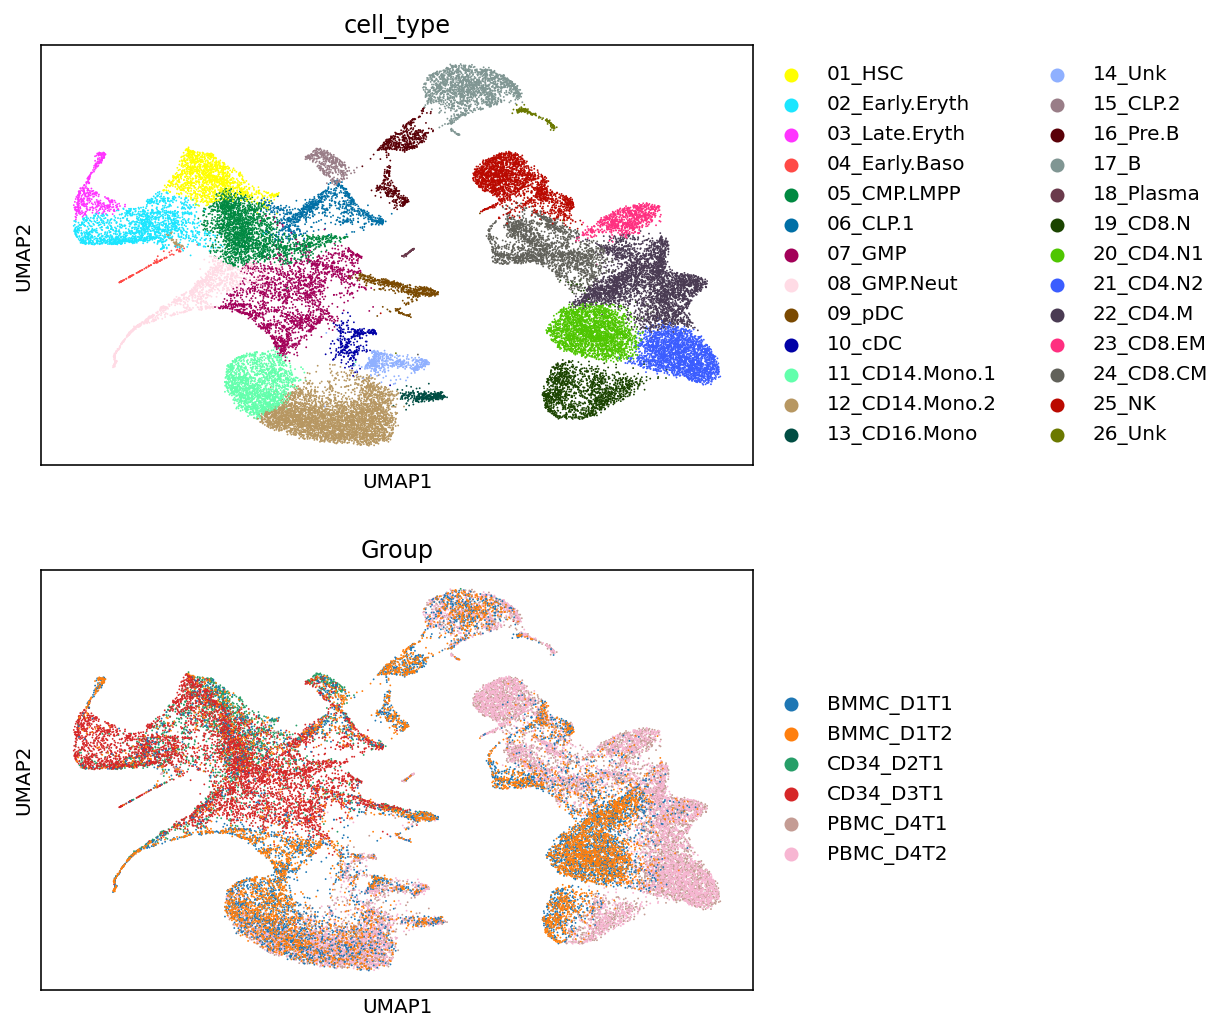

In [27]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

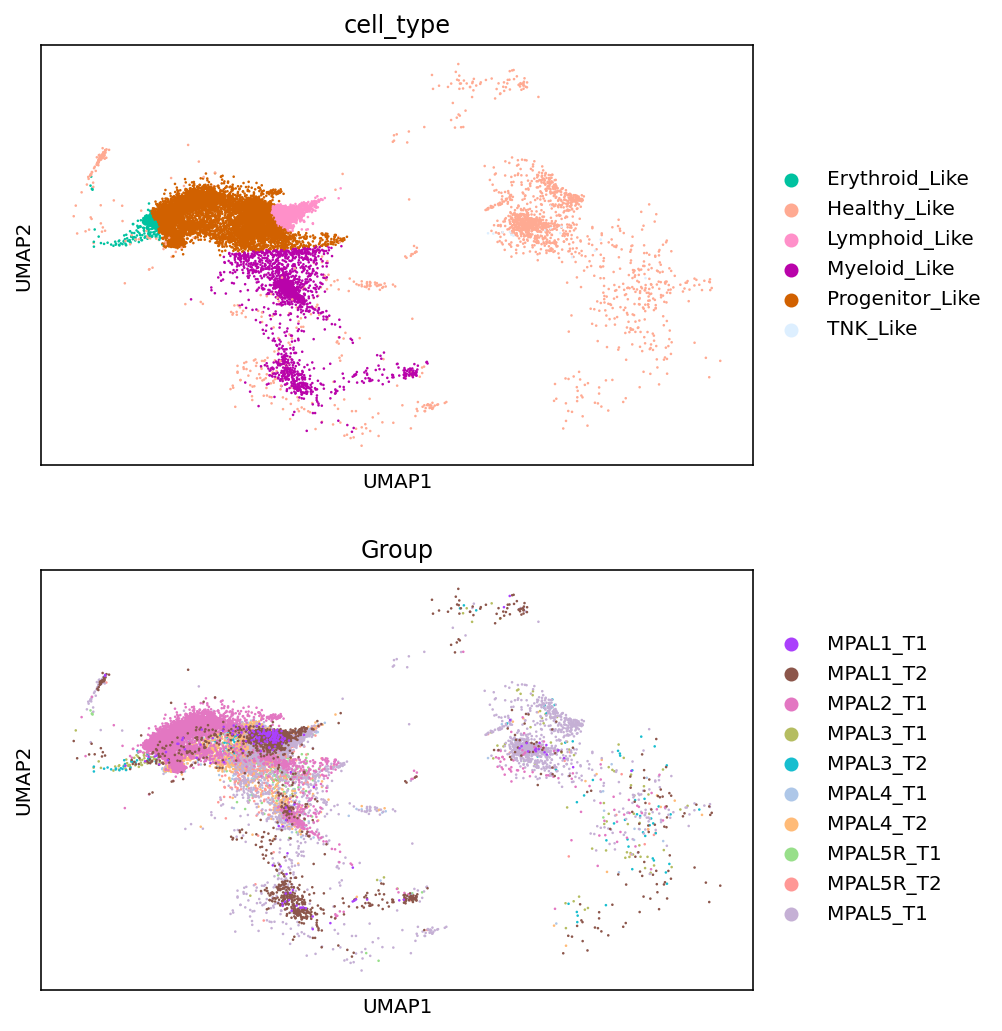

In [28]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

### Running UMAP

In [29]:
sc.pp.neighbors(scrna, random_state=42)
sc.tl.umap(scrna, random_state=42)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:06)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:04)


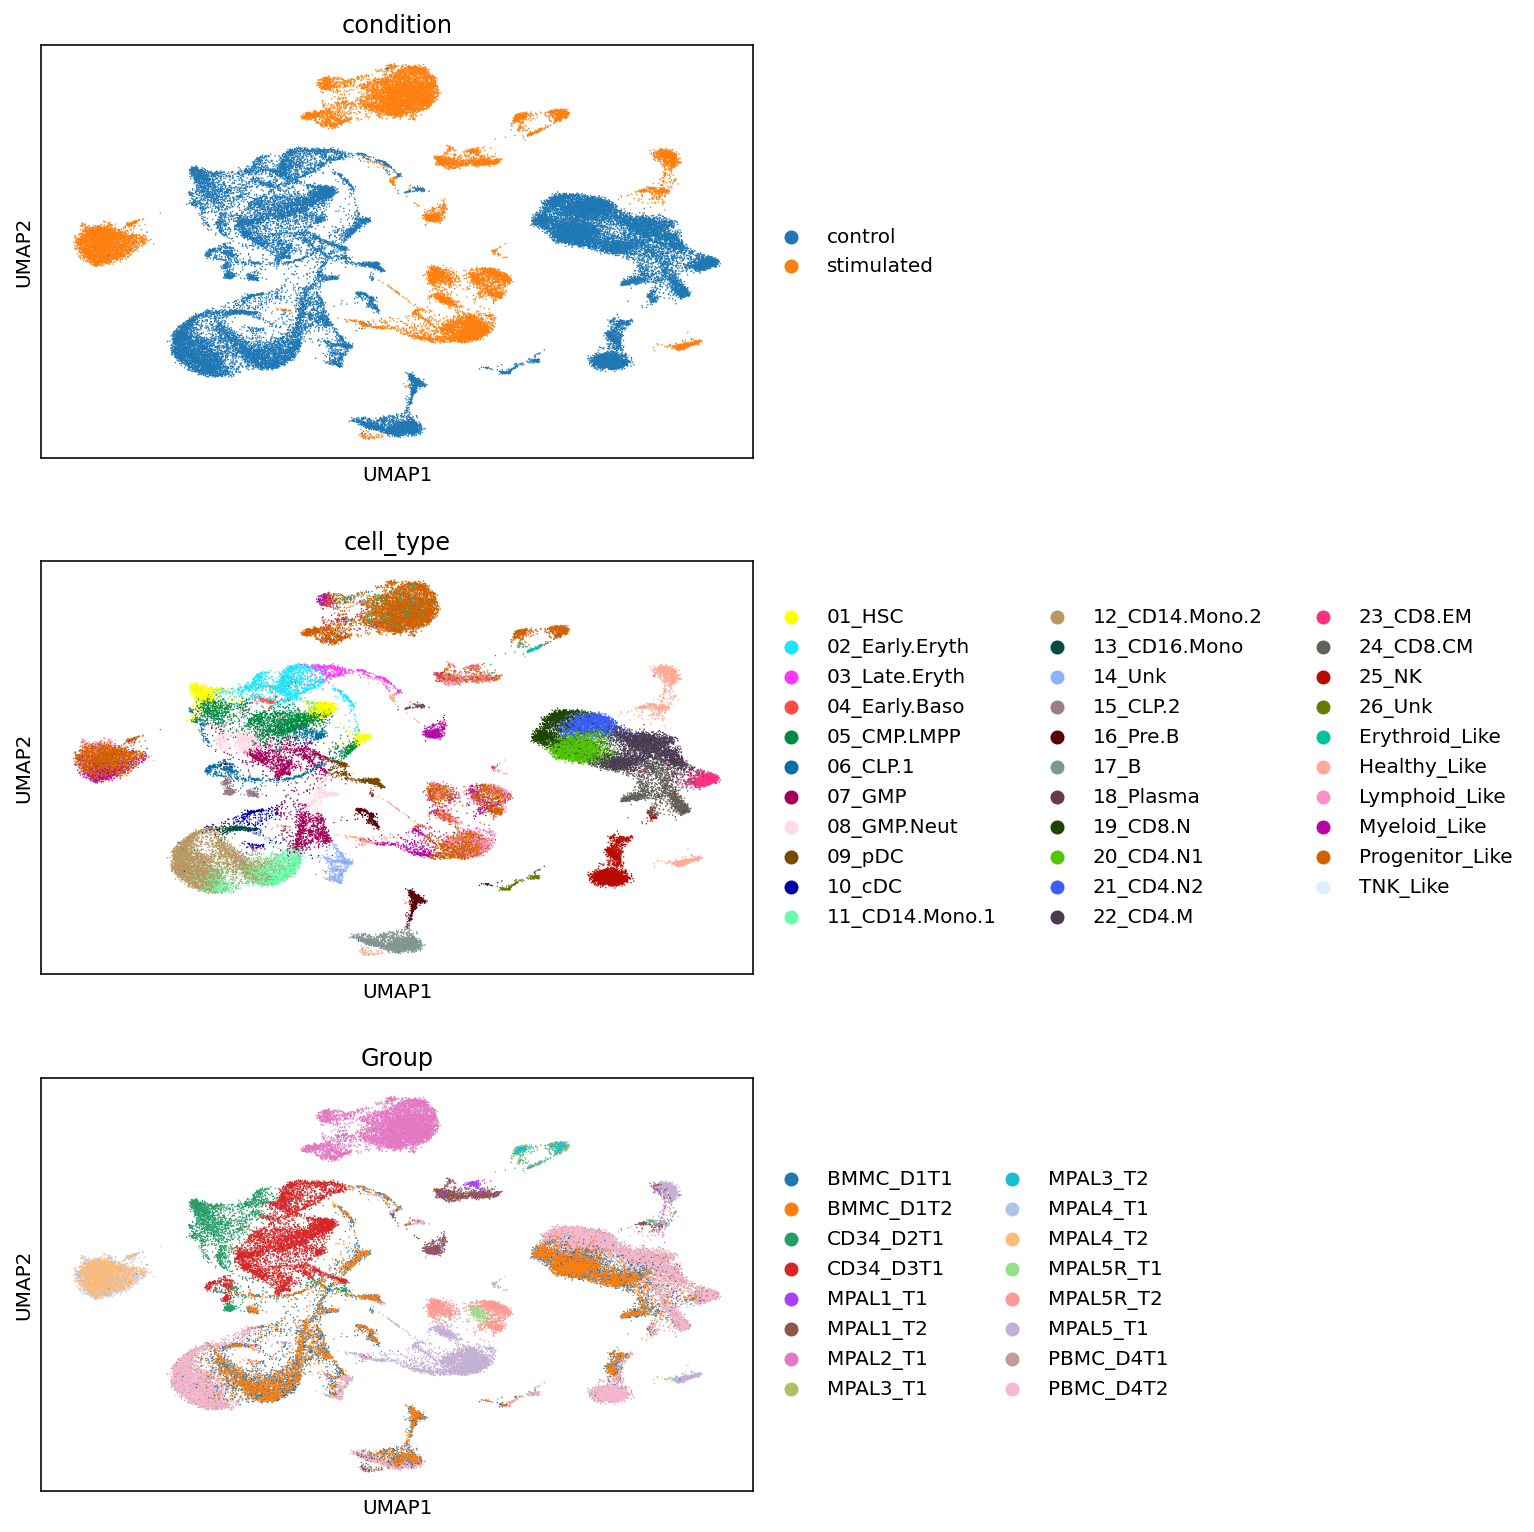

In [30]:
sc.pl.umap(scrna, color=['condition', 'cell_type', 'Group'], ncols=1)

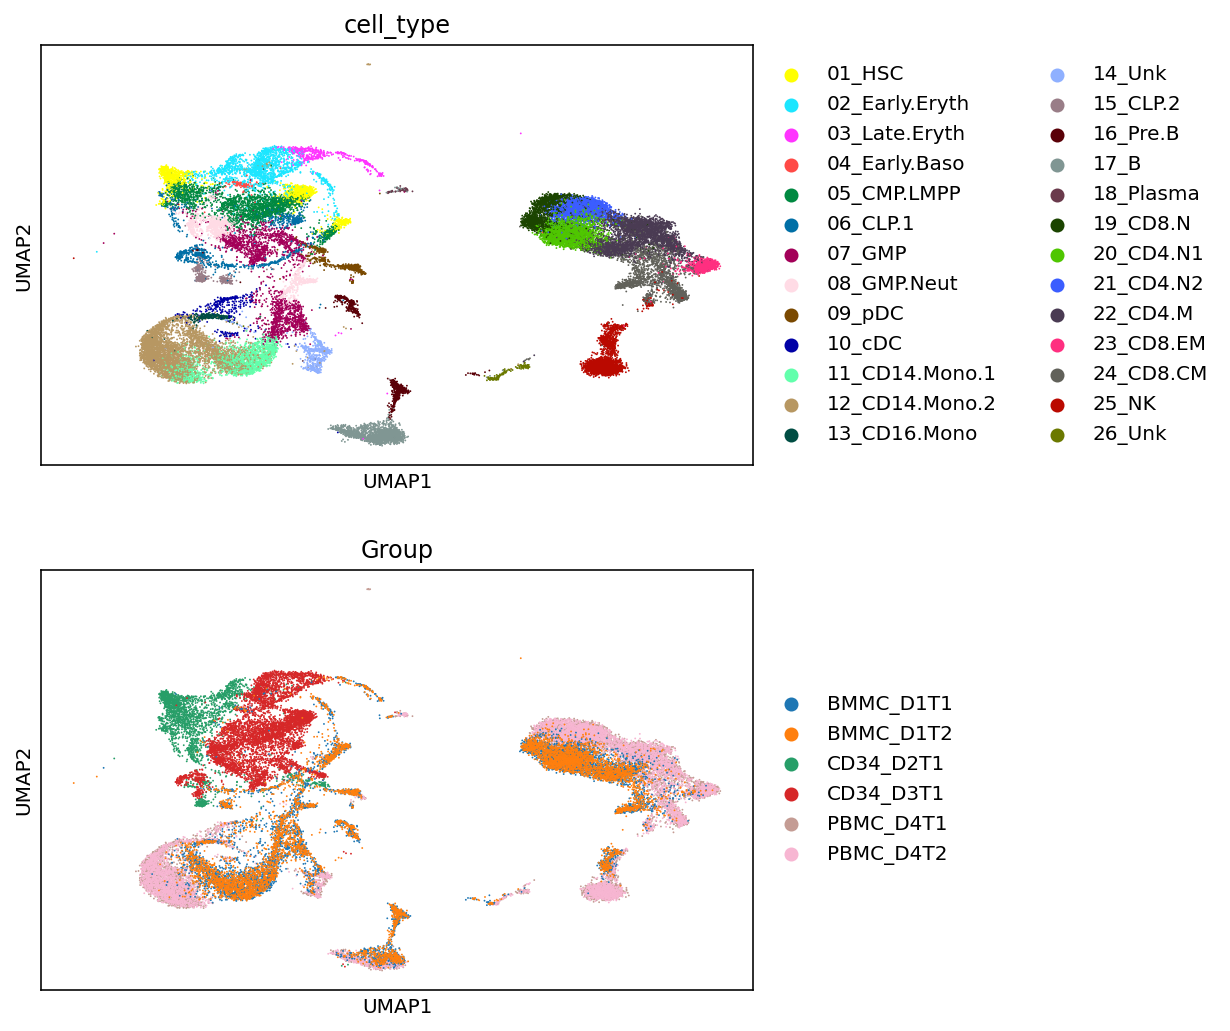

In [31]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

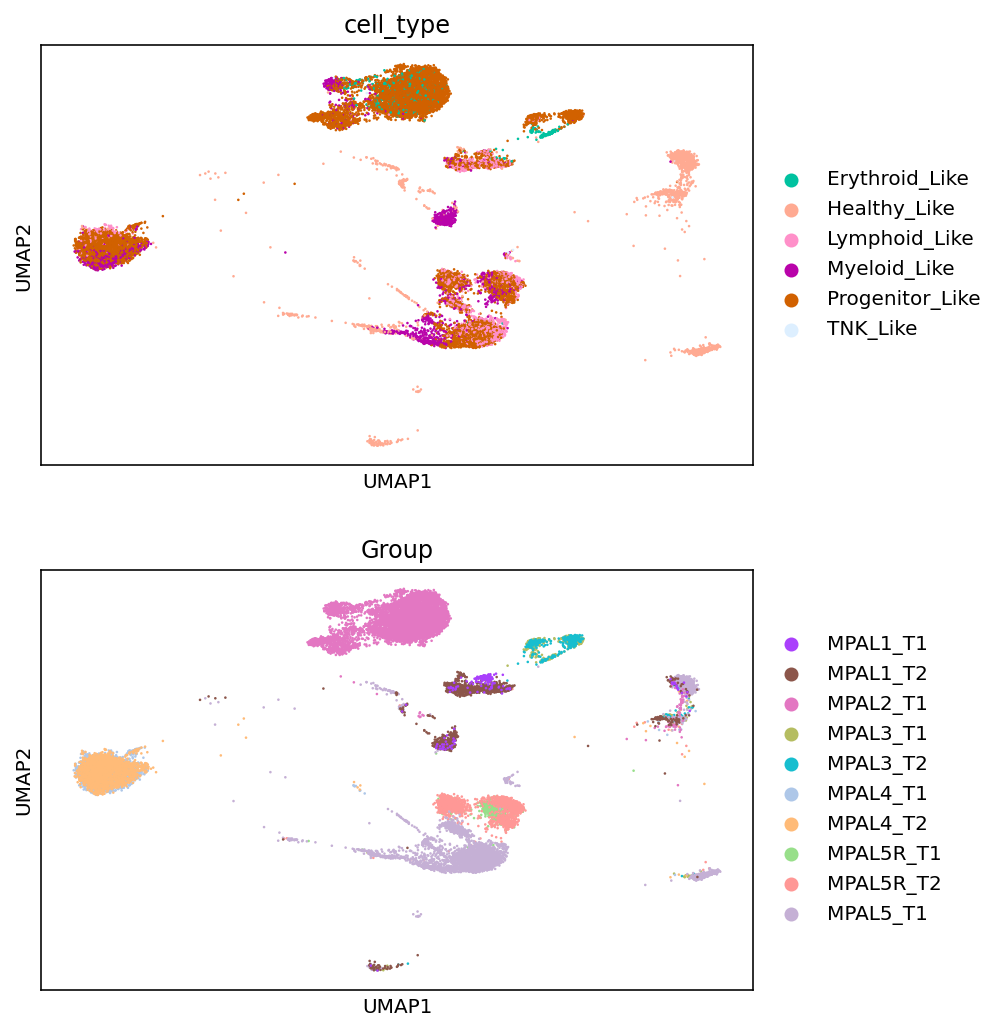

In [32]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

# scATAC-seq

In [ ]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_symbols', cache=True)

var = pd.read_csv(SCATAC_DIR + 'var.csv')
scatac.var = var

obs = pd.read_csv(SCATAC_DIR + 'obs.csv')
scatac.obs = obs

In [ ]:
scatac

In [ ]:
scatac.obs.head()

In [ ]:
scatac.var.head()

## Data Cleaning

In [ ]:
scatac.obs.set_index('Unnamed: 0', inplace=True)

In [ ]:
scatac.var.set_index('Unnamed: 0', inplace=True)

In [ ]:
scatac.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

In [ ]:
scatac.obsm['X_umap'] = scatac.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scatac.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

In [ ]:
scatac.obs['condition'] = scatac.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [ ]:
scatac.obs.head()

In [ ]:
scatac.var.head()

Save the raw data:

In [ ]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-raw.h5ad')

## Binarization

In [ ]:
%time scatac = epi.pp.binarize(scatac, copy=True)
scatac

## Selecting variable peaks

In [ ]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=1000)

In [ ]:
min_score_value = 0.6
nb_feature_selected = 20000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

In [ ]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

## Visualization

### UMAP using coordinates provided by the authors

In [ ]:
sc.pl.umap(scatac, color=['condition', 'cell_type', 'Group'], ncols=1)

In [ ]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

In [ ]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

### Running UMAP

In [ ]:
sc.pp.neighbors(scatac, random_state=42)
sc.tl.umap(scatac, random_state=42)

In [ ]:
sc.pl.umap(scatac, color=['condition', 'cell_type', 'Group'], ncols=1)

In [ ]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

In [ ]:
sc.pl.umap(scatac[scatac.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

# CITE-seq

In [6]:
scadt = sc.read_10x_mtx(SCADT_DIR, var_names='gene_symbols', cache=True)

obs = pd.read_csv(SCADT_DIR + 'obs.csv')
obs.index = obs.iloc[:,0]
scadt.obs = obs

... writing an h5ad cache file to speedup reading next time


In [7]:
scadt.var_names_make_unique()

## Data Cleaning

In [8]:
scadt.obs.drop('Unnamed: 0', axis=1, inplace=True)
scadt.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

scadt.obsm['X_umap'] = scadt.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scadt.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

scadt.obs['condition'] = scadt.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [9]:
scadt.var = scadt.var.drop('gene_ids', axis=1)

In [10]:
scadt.X.data[np.isinf(scadt.X.data)] = 0.0

In [11]:
sc.pp.filter_cells(scadt, min_genes=1)
sc.pp.filter_genes(scadt, min_cells=1)

filtered out 1 cells that have less than 1 genes expressed


## Quality Control

normalizing counts per cell
    finished (0:00:00)


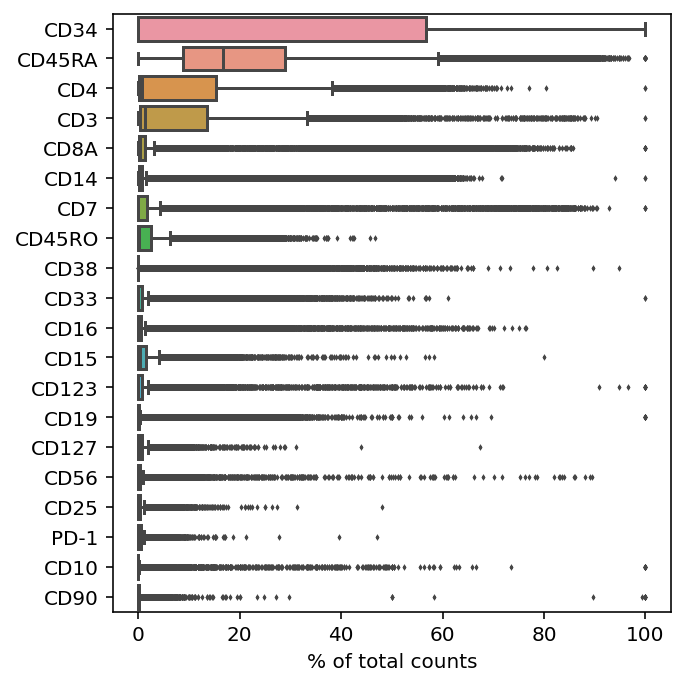

In [12]:
sc.pl.highest_expr_genes(scadt, n_top=20)

In [13]:
scadt.raw = scadt

## Normalization

In [14]:
def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else adata.X)
    )
    return adata

In [15]:
scadt = clr_normalize_each_cell(scadt)

## Visualization

### UMAP form the authors

... storing 'Group' as categorical
... storing 'cell_type' as categorical
... storing 'Barcode' as categorical
... storing 'condition' as categorical


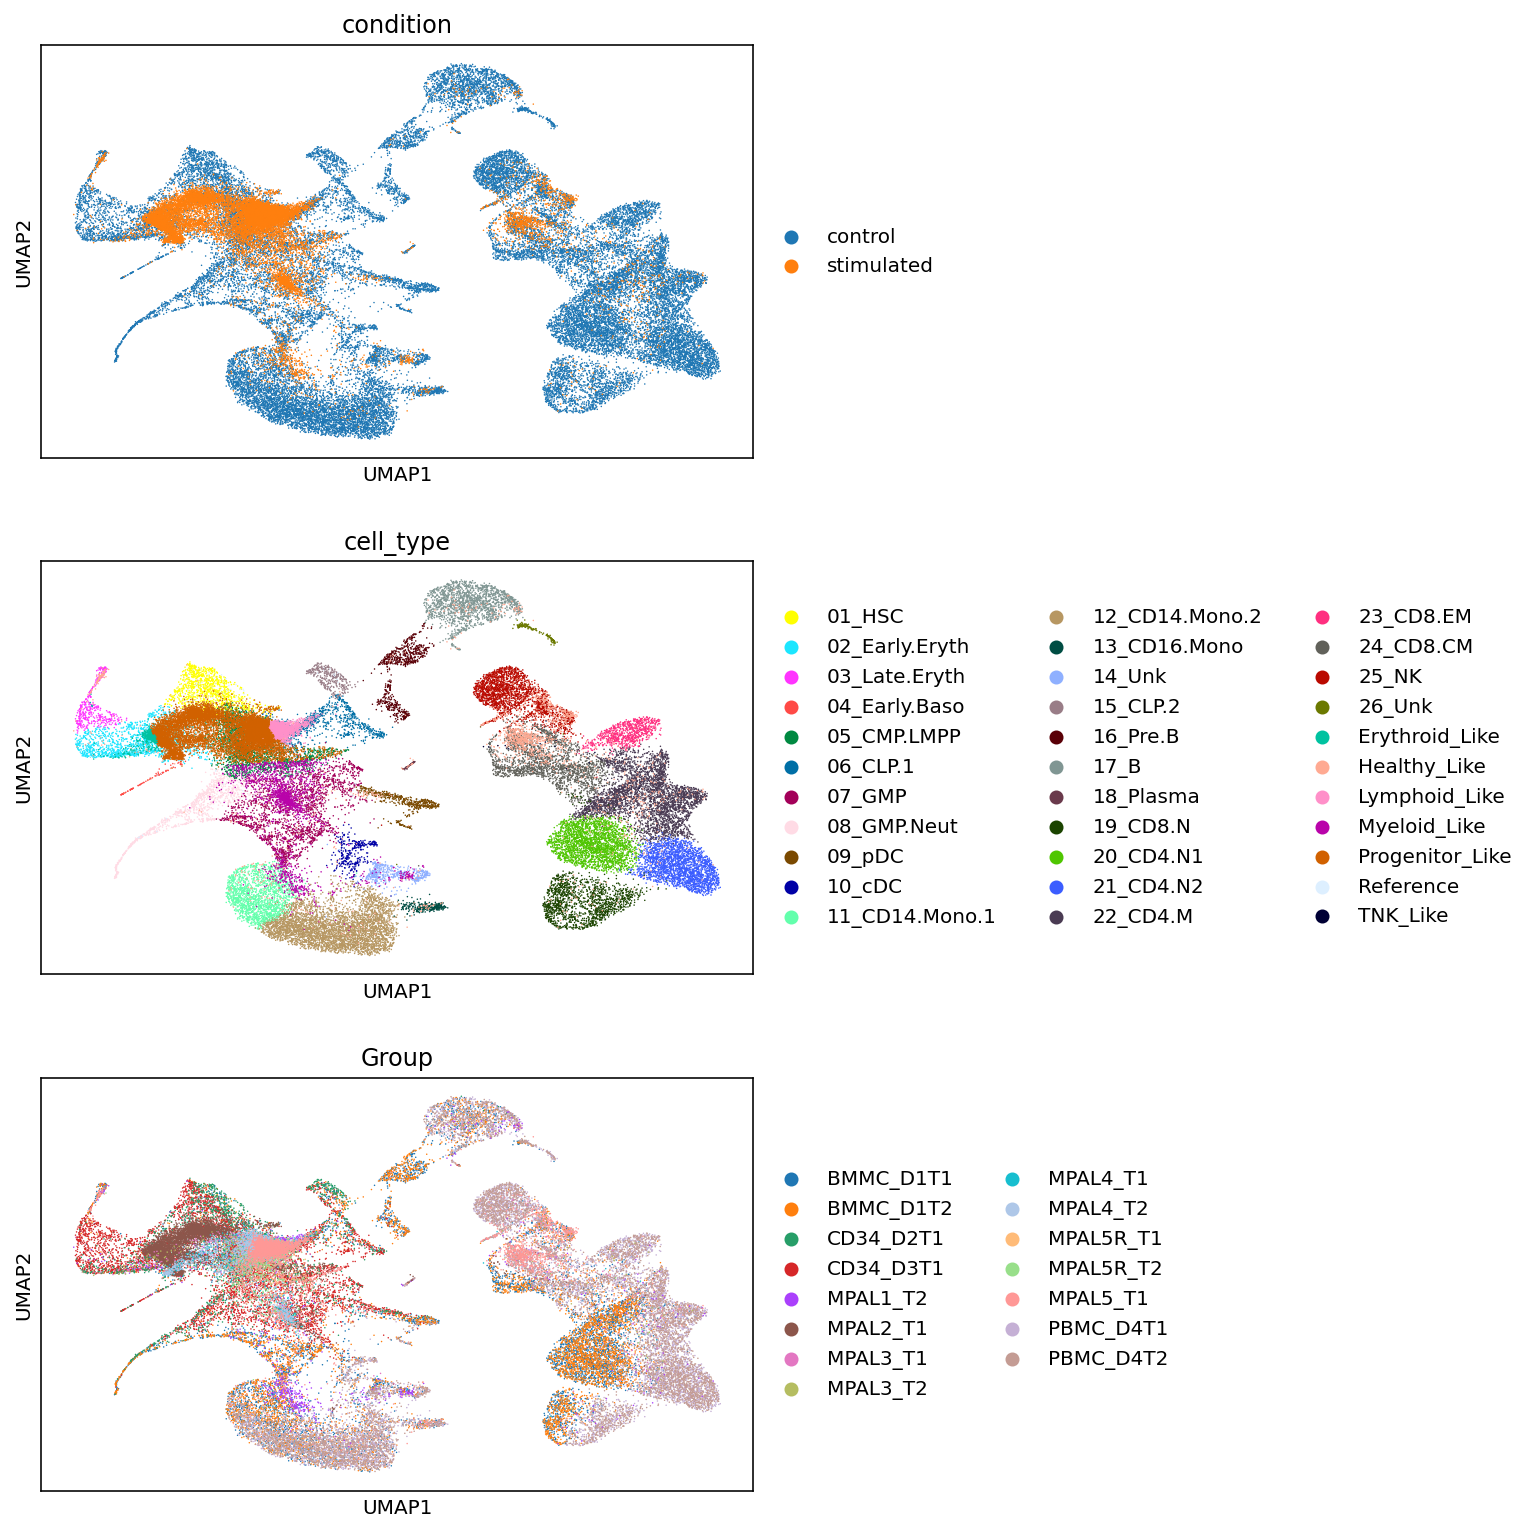

In [16]:
sc.pl.umap(scadt, color=['condition', 'cell_type', 'Group'], ncols=1)

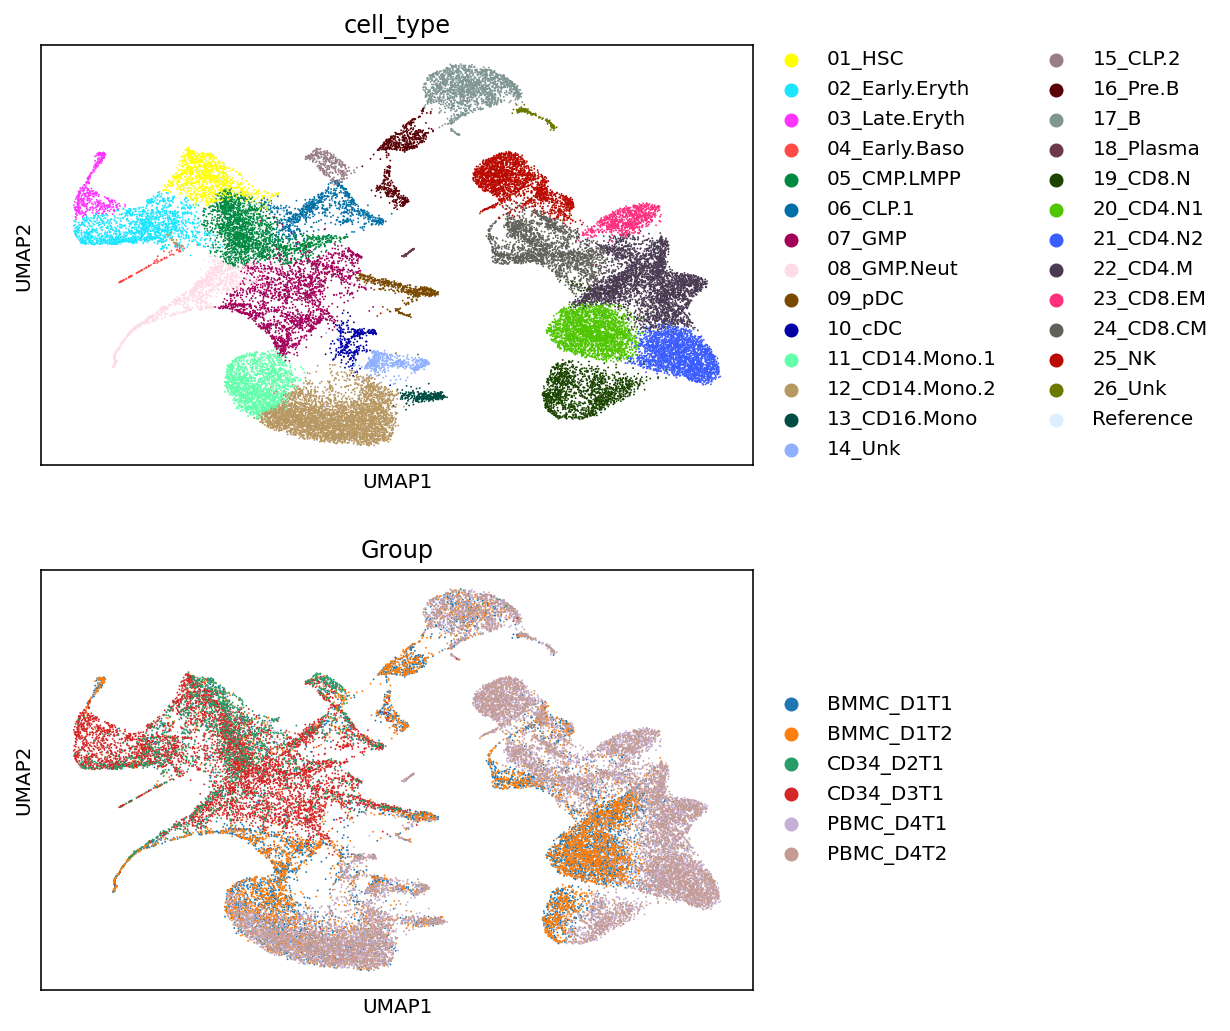

In [17]:
sc.pl.umap(scadt[scadt.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

Trying to set attribute `.uns` of view, copying.


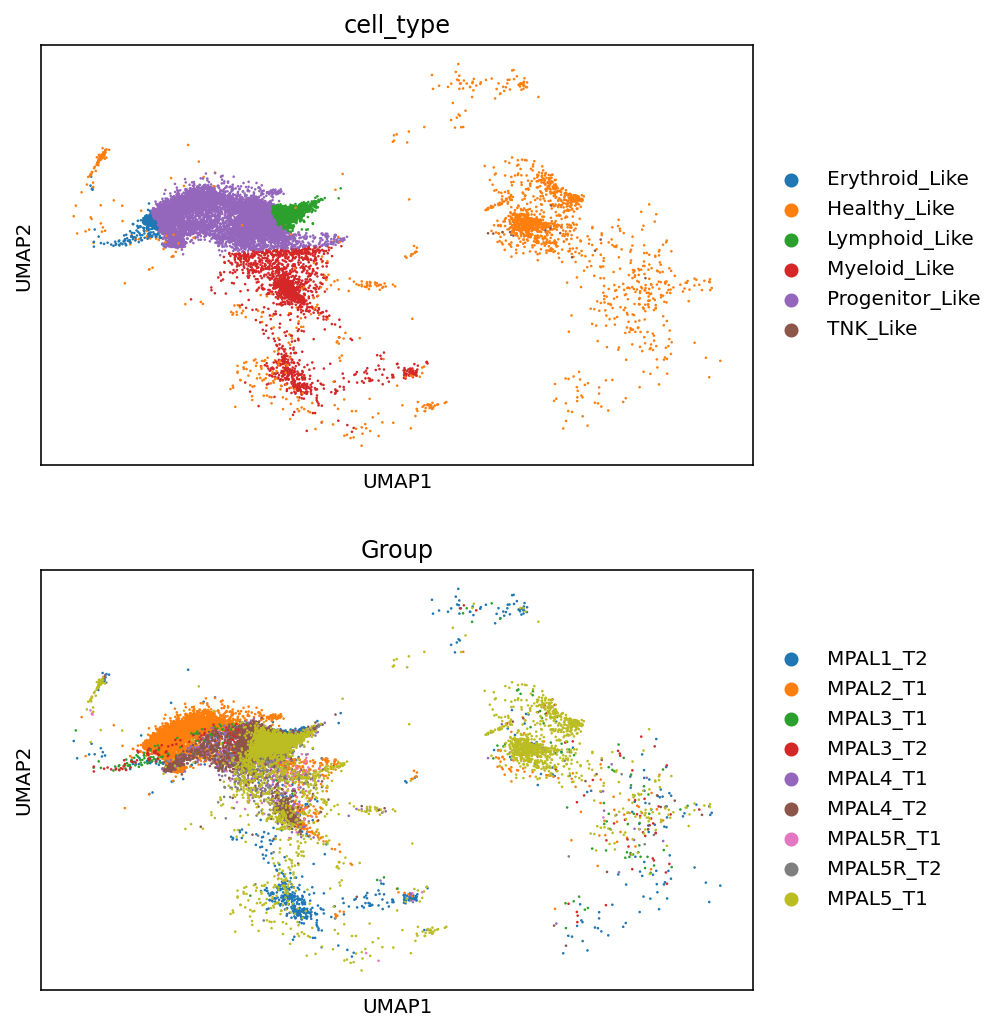

In [18]:
sc.pl.umap(scadt[scadt.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

### Run UMAP

In [19]:
sc.pp.neighbors(scadt, random_state=0)
sc.tl.umap(scadt, random_state=0)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:31)
computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:58)


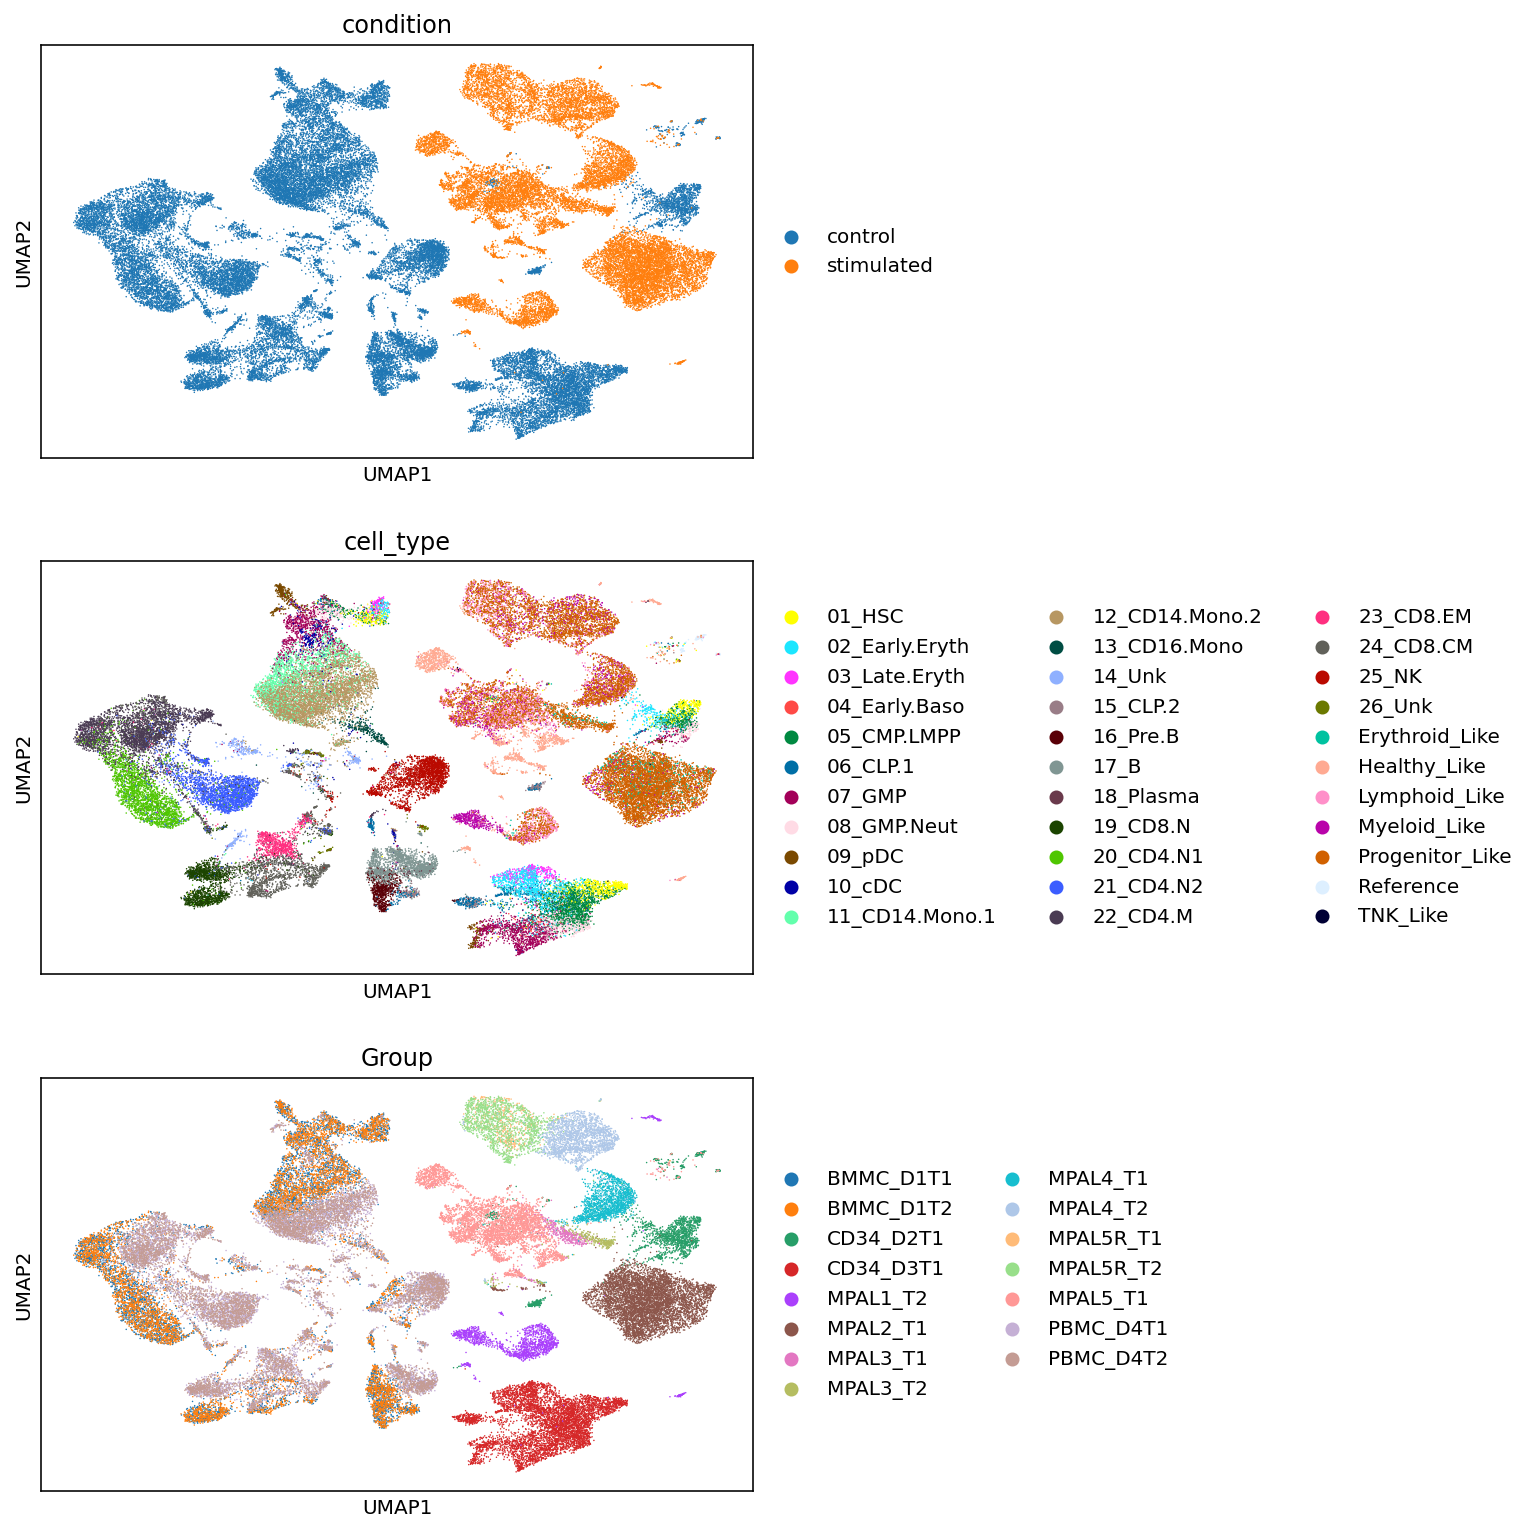

In [20]:
sc.pl.umap(scadt, color=['condition', 'cell_type', 'Group'], ncols=1)

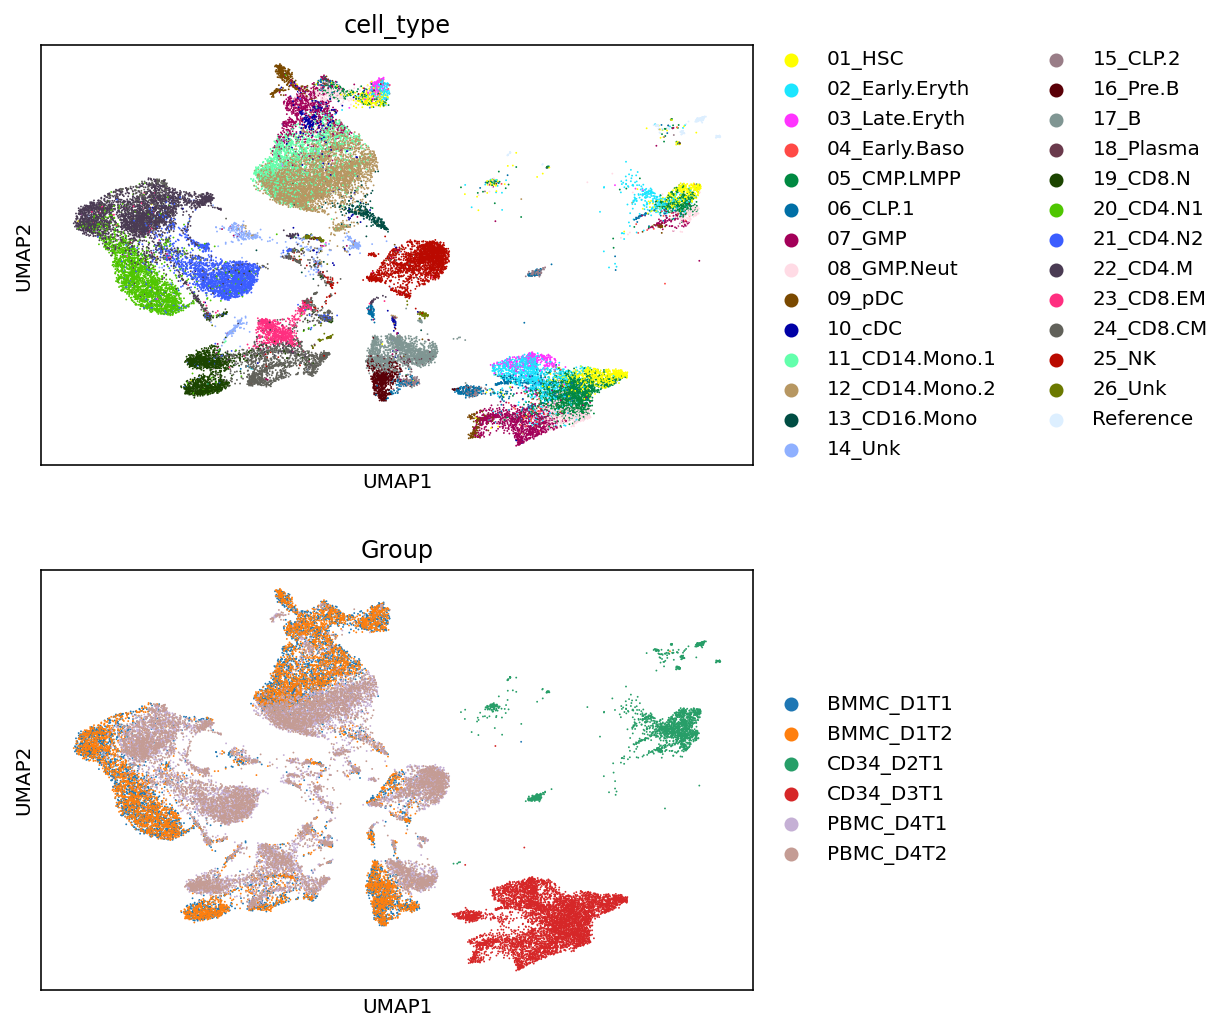

In [21]:
sc.pl.umap(scadt[scadt.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

Trying to set attribute `.uns` of view, copying.


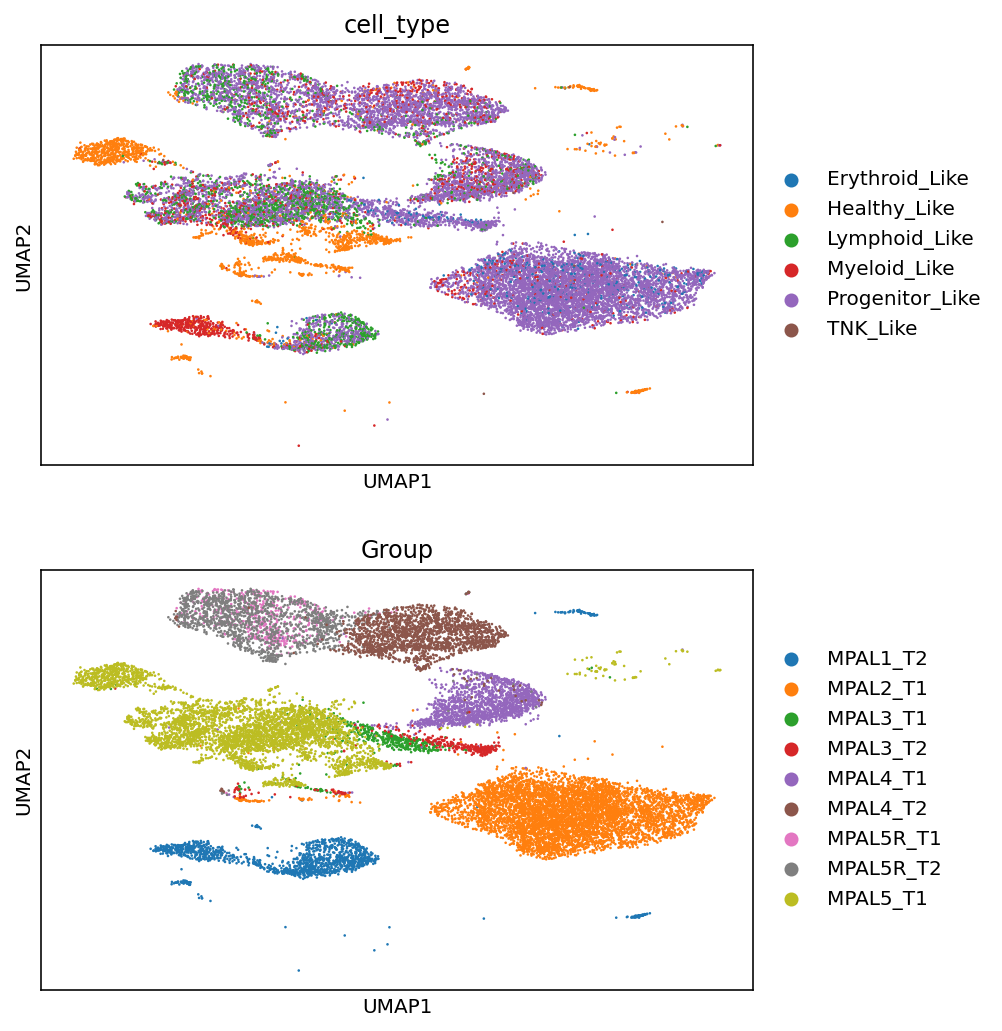

In [22]:
sc.pl.umap(scadt[scadt.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

---
# Save the result

In [ ]:
scrna.write('granja-rna.h5ad')

In [ ]:
scatac.write('granja-atac.h5ad')

In [ ]:
scadt.write('granja-adt.h5ad')

## Control Cells (RNA-seq and ATAC-seq)

In [53]:
scrna_ctrl = scrna[scrna.obs['condition'] == 'control']
scatac_ctrl = scatac[scatac.obs['condition'] == 'control']
print(scrna_ctrl.shape, scatac_ctrl.shape)

(35582, 2999) (35038, 20002)


In [54]:
n_samples = min(scrna_ctrl.shape[0], scatac_ctrl.shape[0], scadt_ctrl.shape[0])
scrna_ctrl_sample_indices = np.random.choice(scrna_ctrl.shape[0], size=n_samples, replace=False)
scatac_ctrl_sample_indices = np.random.choice(scatac_ctrl.shape[0], size=n_samples, replace=False)
scrna_ctrl = scrna_ctrl[scrna_ctrl_sample_indices]
scatac_ctrl = scatac_ctrl[scatac_ctrl_sample_indices]
print(scrna_ctrl.shape, scatac_ctrl.shape, scadt_ctrl)

(35038, 2999) (35038, 2999)


In [55]:
%time scrna_ctrl.write(SCRNA_DIR + 'expressions-ctrl.h5ad')

CPU times: user 308 ms, sys: 240 ms, total: 548 ms
Wall time: 7.82 s


In [56]:
%time scatac_ctrl.write_h5ad(SCATAC_DIR + 'peaks-binary-ctrl.h5ad')

CPU times: user 1.04 s, sys: 1.85 s, total: 2.9 s
Wall time: 12.9 s


## All Cells (RNA-seq and ATAC-seq)

In [59]:
n_samples = min(scrna.shape[0], scatac.shape[0], scadt.shape[0])
scrna_sample_indices = np.random.choice(scrna.shape[0], size=n_samples, replace=False)
scatac_sample_indices = np.random.choice(scatac.shape[0], size=n_samples, replace=False)
scrna = scrna[scrna_sample_indices]
scatac = scatac[scatac_sample_indices]
print(scrna.shape, scatac.shape)

(53638, 2999) (53638, 2999)


In [60]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 324 ms, sys: 272 ms, total: 596 ms
Wall time: 1.73 s


In [61]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

CPU times: user 1.62 s, sys: 2.76 s, total: 4.38 s
Wall time: 17.2 s


## save CITE-seq

Since we first processed only rna-seq and atac-seq, for protein data we leave only cells that are already saved in expressions-ctrl.

In [24]:
scrna = sc.read(SCRNA_DIR + 'expressions-ctrl.h5ad')

In [33]:
scrna.obs_names = scrna.obs_names.astype(str)

In [37]:
com_index = set(scrna.obs.index) & set(scadt.obs.index)
scrna_paired = scrna[scrna.obs.index.isin(com_index)]
scadt = scadt[scadt.obs.index.isin(com_index)]
print(scrna_paired.shape, scadt.shape)

(34902, 3172) (34902, 21)


In [38]:
%time scrna_paired.write_h5ad(SCRNA_DIR + 'expressions-ctrl-paired.h5ad')

CPU times: user 600 ms, sys: 1.27 s, total: 1.87 s
Wall time: 2.4 s


In [39]:
%time scadt.write_h5ad(SCADT_DIR + 'protein-ctrl.h5ad')

CPU times: user 155 ms, sys: 155 ms, total: 310 ms
Wall time: 424 ms
